In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/denizaydin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
x_train = pd.read_csv("x_train_with_ratios.csv")
y_train = pd.read_csv("Y_train.csv", index_col=0)
df = x_train.join(y_train["prdtypecode"])

image_dir = 'images/image_train_zoomed' 

# Filter and encode
min_content_ratio = 0.04
df = df[df["content_ratio"] >= min_content_ratio].reset_index(drop=True)
le = LabelEncoder()
df["label"] = le.fit_transform(df["prdtypecode"])
num_classes = df["label"].nunique()
df.head()

,designation,description,productid,imageid,content_ratio,prdtypecode,label
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,0.118976,10,0
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,0.188640,2280,18
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,0.505352,50,2
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,0.512820,1280,7
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,0.219128,2705,25


In [4]:
df.to_csv("df.csv", index=False)

In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [ ]:
def generate_augmented_class_samples(df_class, n_target):
    """
    Simulate augmenting df_class samples up to n_target rows.
    Flag for augmentation only if the current samples are less than n_target.
    """
    current_count = len(df_class)
    if current_count >= n_target:
        # Just sample without augmentation
        df_sampled = df_class.sample(n=n_target, replace=False, random_state=42).copy()
        df_sampled["augmented"] = False
        return df_sampled
    else:
        # Duplicate existing samples to reach n_target
        repeats = n_target // current_count
        remainder = n_target % current_count
        
        dfs = []
        # Original samples without augmentation flag
        df_orig = df_class.copy()
        df_orig["augmented"] = False
        dfs.append(df_orig)
        
        # Augmented duplicates with augmented=True
        for _ in range(repeats - 1):
            df_dup = df_class.sample(n=current_count, replace=True, random_state=42).copy()
            df_dup["augmented"] = True
            dfs.append(df_dup)
        
        if remainder > 0:
            df_rem = df_class.sample(n=remainder, replace=True, random_state=42).copy()
            df_rem["augmented"] = True
            dfs.append(df_rem)
        
        df_balanced_class = pd.concat(dfs).reset_index(drop=True)
        return df_balanced_class

# Define how many samples you want per class (target count)
desired_count = int(df["label"].value_counts().median())  # Or set manually

balanced_parts = []

for label in train_df["label"].unique():
    df_class = train_df[train_df["label"] == label]
    
    # Undersample if the class is too big, else augment
    if len(df_class) > desired_count:
        # Undersample to desired count (no augmentation)
        df_sampled = df_class.sample(n=desired_count, random_state=42).copy()
        df_sampled["augmented"] = False
        balanced_parts.append(df_sampled)
    else:
        # Augment smaller classes
        n_target = desired_count
        class_balanced = generate_augmented_class_samples(df_class, n_target)
        balanced_parts.append(class_balanced)

# Combine all classes and shuffle
df_train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

# Inspect balanced class distribution
print(df_train_balanced["label"].value_counts())
print(f"Total samples in balanced dataset: {len(df_train_balanced)}")

label
4     2637
6     2637
17    2637
0     2637
16    2637
7     2637
20    2637
26    2637
18    2637
14    2637
9     2637
15    2637
12    2637
3     2637
19    2637
24    2637
25    2637
22    2637
21    2637
11    2637
23    2637
1     2637
5     2637
10    2637
2     2637
13    2637
8     2637
Name: count, dtype: int64
Total samples in balanced dataset: 71199


In [7]:
df_train_balanced.shape

(71199, 8)

In [8]:
df_train_balanced.head()

,designation,description,productid,imageid,content_ratio,prdtypecode,label,augmented
0,Magnet Père Dodu - Régions D'europe - 48 - Orl...,NaN,73192148,844757331,0.666000,1140,4,False
1,Lot De 3 Revues Aquarium Magazine Et 1 Aquariu...,NaN,3744929595,1240241895,0.860000,2403,19,False
2,Living Room Dressing Table Desktop Sundries St...,Living Room Dressing Table Desktop Sundries St...,4057530663,1282883250,1.000000,1560,13,False
3,Rc280 Telecommande Pour Tcl Roku Tlc Tv 40fs37...,Description: <br />Type d&#39;element: Teleco...,4108382685,1292292689,0.611184,50,2,False
4,Tout-petit bébé Enfants 15pc Chaussettes bébé ...,Tout-petit bébé Enfants 15pc Chaussettes bébé ...,3898729891,1261430706,0.676396,1301,10,True


In [ ]:
train_df.to_csv("preprocessing/train_df.csv", index=False)
df_train_balanced.to_csv("preprocessing/df_train_balanced.csv", index=False)
val_df.to_csv("preprocessing/val_df.csv", index=False)

In [4]:
df_train_balanced = pd.read_csv("preprocessing/df_train_balanced.csv")
val_df = pd.read_csv("preprocessing/val_df.csv")
train_df = pd.read_csv("preprocessing/train_df.csv")

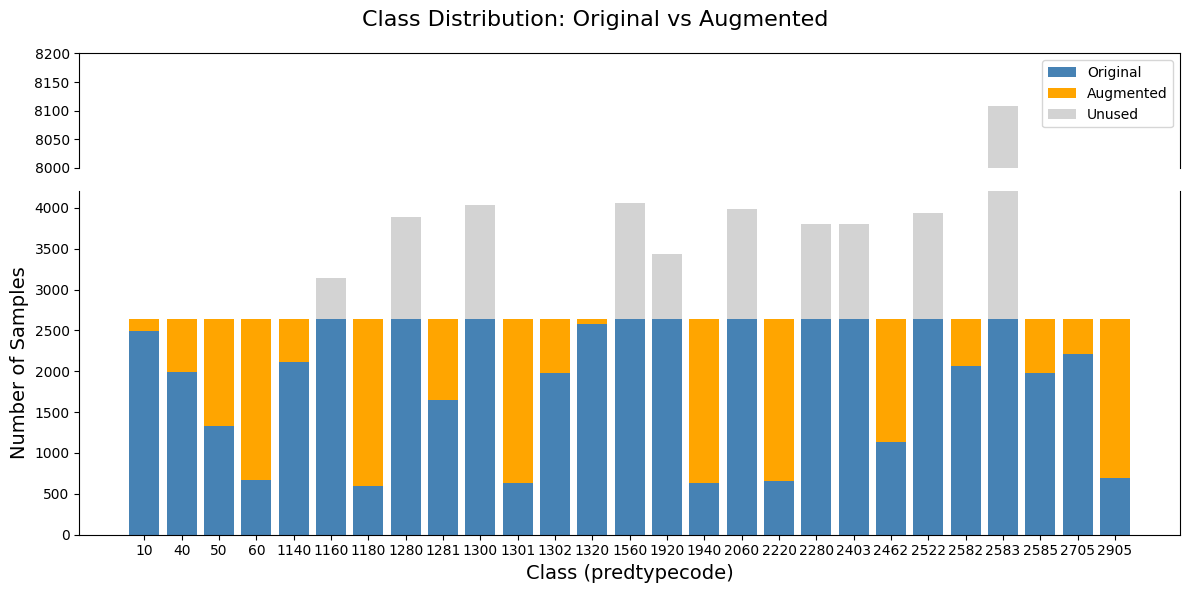

In [ ]:
original_counts = train_df['prdtypecode'].value_counts().sort_index()

# Count total balanced samples per class
balanced_total = df_train_balanced['prdtypecode'].value_counts().sort_index()

# Count augmented samples per class
augmented_counts = df_train_balanced[df_train_balanced['augmented'] == True]['prdtypecode'].value_counts().sort_index()
augmented_counts = augmented_counts.reindex(balanced_total.index, fill_value=0)
# Calculate original_used = total - augmented
original_used = balanced_total - augmented_counts

# Calculate unused originals (i.e., original samples not used in balanced dataset)
original_unused = original_counts - original_used
original_unused = original_unused.clip(lower=0)  # Avoid negative values

# Align all indices to have same x-axis
all_classes = original_counts.index
all_classes_str = all_classes.astype(str)

# Fill missing values with 0
original_used = original_used.reindex(all_classes, fill_value=0)
augmented_counts = augmented_counts.reindex(all_classes, fill_value=0)
original_unused = original_unused.reindex(all_classes, fill_value=0)

original_used = original_used.rename(index=str)
augmented_counts = augmented_counts.rename(index=str)
original_unused = original_unused.rename(index=str)
# Plot
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

# Plot on both axes
ax0.bar(all_classes_str, original_used, color='steelblue', label='Original')
ax0.bar(all_classes_str, augmented_counts, bottom=original_used, color='orange', label='Augmented')
ax0.bar(all_classes_str, original_unused, bottom=original_used + augmented_counts, color='lightgray', label='Unused')

ax1.bar(all_classes_str, original_used, color='steelblue')
ax1.bar(all_classes_str, augmented_counts, bottom=original_used, color='orange')
ax1.bar(all_classes_str, original_unused, bottom=original_used + augmented_counts, color='lightgray')

ax0.set_ylim(8000, 8200)
ax1.set_ylim(0, 4200)

# Hide x-axis for top plot
plt.setp(ax0.get_xticklabels(), visible=False)

ax0.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax0.tick_params(bottom=False)
ax1.tick_params(top=False)

fig.suptitle("Class Distribution: Original vs Augmented", fontsize=16)
ax1.set_xlabel("Class (predtypecode)", fontsize=14)
ax1.set_ylabel("Number of Samples", fontsize=14)
ax0.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [3]:
df_train_balanced = pd.read_csv("preprocessing/df_train_balanced.csv")
val_df = pd.read_csv("preprocessing/val_df.csv")
df = pd.read_csv("preprocessing/df.csv")
train_df = pd.read_csv("preprocessing/train_df.csv")

In [4]:
def get_class_distribution(df, name):
    distribution = df['prdtypecode'].value_counts(normalize=True).sort_index() * 100
    return pd.DataFrame({name: distribution})

# Get distributions
df_dist = get_class_distribution(df, 'Full Dataset')
train_dist = get_class_distribution(train_df, 'Train Set')
val_dist = get_class_distribution(val_df, 'Validation Set')

# Combine into a single table
distribution_comparison = pd.concat([df_dist, train_dist, val_dist], axis=1).fillna(0).round(2)

# Show comparison
print(distribution_comparison)

             Full Dataset  Train Set  Validation Set
prdtypecode                                         
10                   3.68       3.68            3.68
40                   2.95       2.95            2.95
50                   1.97       1.97            1.98
60                   0.98       0.98            0.98
1140                 3.12       3.12            3.12
1160                 4.65       4.65            4.65
1180                 0.89       0.89            0.89
1280                 5.75       5.75            5.76
1281                 2.44       2.44            2.44
1300                 5.96       5.96            5.96
1301                 0.93       0.93            0.93
1302                 2.93       2.93            2.93
1320                 3.81       3.81            3.80
1560                 6.00       6.00            6.00
1920                 5.09       5.09            5.09
1940                 0.94       0.94            0.94
2060                 5.90       5.90          